# Plotting Benchmark Results

### Preparation

#### Dependencies

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

#### R dependencies (obsolete)

In [217]:
%load_ext rpy2.ipython

In [218]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings('ignore', category=RRuntimeWarning)

In [219]:
%R require(MASS)
%R require(ggplot2)
%R require(ggpmisc)
%R require(reshape2)
%R require(rgl)

array([1], dtype=int32)

#### Graph style

In [4]:
%matplotlib inline

In [5]:
mpl.rc('figure', figsize=(4,4))

In [6]:
mpl.rc('lines', markersize=4)

#### Helper functions

Convert "HH:MM:SS" string to seconds

In [7]:
def hms2s(hms):
    return sum(float(x) * 60 ** i for i, x in enumerate(reversed(hms.split(':'))))

Save figure to PDF

In [8]:
def savepdf(fig, fp):
    fig.tight_layout()
    fig.savefig(fp, bbox_to_inches='tight')

### Input data size

#### Genomes

Date retrieved from: [https://www.ncbi.nlm.nih.gov/refseq/statistics/](https://www.ncbi.nlm.nih.gov/refseq/statistics/).

In [47]:
df = pd.read_table('data/ncbi.complete.tsv', index_col=0)
df.head()

,month,day,year,species,total,nucleotides,transcripts,proteins
index,,,,,,,,
1,Jun,30,2003,2005,1061675,64729,211803,785143
2,Oct,21,2003,2124,1097404,64805,201312,831287
3,Jan,14,2004,2218,1101244,58793,198043,844408
4,Mar,24,2004,2358,1193457,59395,204589,929473
5,May,2,2004,2395,1255613,60991,217164,977458


In [48]:
df['date'] = pd.to_datetime(df['month'] + ' ' + df['day'].map(str) + ' ' + df['year'].map(str))

In [49]:
df = df.query('date >= "2015-09-01"')

In [74]:
reg = sp.stats.linregress(df['date'].apply(mpl.dates.date2num).values,
                          df['species'].values)
reg

LinregressResult(slope=26.27793687320176, intercept=-19282893.544846494, rvalue=0.9970309043311375, pvalue=3.0082782521017387e-19, stderr=0.50737275441892304)

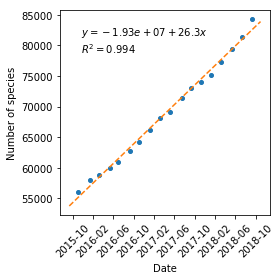

In [80]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['date'], df['species'], 'o')
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x
plt.xticks(rotation=45)
plt.plot(x, y, '--')
plt.text(0.1, 0.80, '$\it{y} = %.3g %+.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Date')
plt.ylabel('Number of species')
fig.tight_layout()
fig.savefig('ncbi.species.pdf', bbox_to_inches='tight')

In [85]:
# On March 07, 2017
reg.intercept + reg.slope * mpl.dates.date2num(pd.to_datetime('2017-03-07'))

68047.778894916177

In [86]:
# On Jan. 01, 2019
reg.intercept + reg.slope * mpl.dates.date2num(pd.to_datetime('2019-01-01'))

85522.606915596873

In [ ]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['Taxa'], df['Wall'], 'o')
plt.xticks(df['Taxa'].unique())
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x ** 1.4
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g %+.3g \it{x}^{1.4}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)
plt.text(0.2, 0.85, '(RAxML)', size=12, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('raxml.taxa.pdf', bbox_to_inches='tight')

#### Genes

Protein clusters present in 100 or more selected genomes

In [131]:
df = pd.read_table('data/g100.summary.tsv.bz2', index_col=0)
df.head()

,90_mems,100_mems,raw_mems,genomes,genomes_in,uniq_in,all_in,uniq_in_aas
#cluster,,,,,,,,
AAAC01000001.1_4976,145,1518,2938,2753,117,103,155,33190
AAFV01000278.1_2,613,1162,2265,2242,515,441,597,42417
AAKL01000024.1_28,336,1063,1385,1250,180,182,252,74468
AARM02000317.1_1,598,752,3350,3338,172,127,1485,40501
AARY02000029.1_9,119,670,3222,3162,782,319,1085,19473


In [119]:
df.shape[0]

45692

Average sequence length

In [120]:
df['seq_len'] = df['uniq_in_aas'] / df['uniq_in']

Number of genomes represented by each cluster

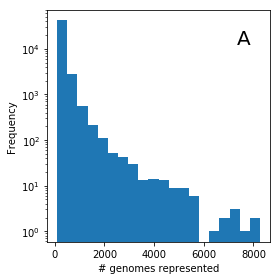

In [291]:
ax = df['genomes_in'].hist(bins=20, log=True, grid=False)
ax.set_xlabel("# genomes represented")
ax.set_ylabel("Frequency")
ax.text(0.85, 0.85, 'A', size=20, transform=ax.transAxes)
savepdf(ax.get_figure(), 'size.genomes.pdf')

Number of unique sequences per cluster

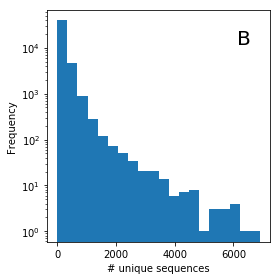

In [292]:
ax = df['uniq_in'].hist(bins=20, log=True, grid=False)
ax.set_xlabel("# unique sequences")
ax.set_ylabel("Frequency")
ax.text(0.85, 0.85, 'B', size=20, transform=ax.transAxes)
savepdf(ax.get_figure(), 'size.unique.pdf')

Average lengths of unique sequences per cluster

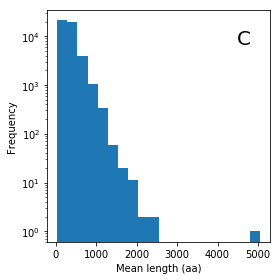

In [293]:
ax = df['seq_len'].hist(bins=20, log=True, grid=False)
ax.set_xlabel("Mean length (aa)")
ax.set_ylabel("Frequency")
ax.text(0.85, 0.85, 'C', size=20, transform=ax.transAxes)
savepdf(ax.get_figure(), 'size.length.pdf')

Number of all sequences per cluster

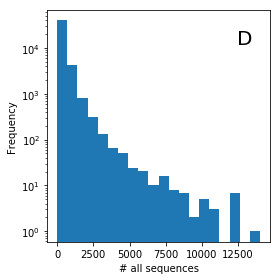

In [294]:
ax = df['all_in'].hist(bins=20, log=True, grid=False)
ax.set_xlabel("# all sequences")
ax.set_ylabel("Frequency")
ax.text(0.85, 0.85, 'D', size=20, transform=ax.transAxes)
savepdf(ax.get_figure(), 'size.all.pdf')

In [114]:
df.head()

,90_mems,100_mems,raw_mems,genomes,genomes_in,uniq_in,all_in,uniq_in_aas
#cluster,,,,,,,,
AAAC01000001.1_4976,145,1518,2938,2753,117,103,155,33190
AAFV01000278.1_2,613,1162,2265,2242,515,441,597,42417
AAKL01000024.1_28,336,1063,1385,1250,180,182,252,74468
AARM02000317.1_1,598,752,3350,3338,172,127,1485,40501
AARY02000029.1_9,119,670,3222,3162,782,319,1085,19473


Total number of sequences

In [117]:
df['all_in'].sum()

17955384

Total number of unique sequences

In [115]:
df['uniq_in'].sum()

10228602

Total number of amino acids in those sequences.

In [116]:
df['uniq_in_aas'].sum()

3460927606

### Sequence alignment

#### MAFFT (obsolete)

In [103]:
df = pd.read_table('data/mafft_taxa.tsv')
df.head()

,Gene,Taxa,Wall,CPU,RAM
0,p0031,10,0.92,0.45,14744
1,p0031,20,1.47,1.31,17440
2,p0031,50,6.29,6.14,20500
3,p0031,100,23.61,23.51,33068
4,p0031,200,105.97,105.89,58796


In [104]:
df = df.query('Gene != "p0060" and Taxa <= 200')

In [105]:
reg = sp.stats.linregress(df['Taxa'].values ** 2, df['Wall'].values)
reg

LinregressResult(slope=0.0035611452927609148, intercept=0.090109896734304584, rvalue=0.9759384857125234, pvalue=9.6396153474707916e-27, stderr=0.00012906950310421432)

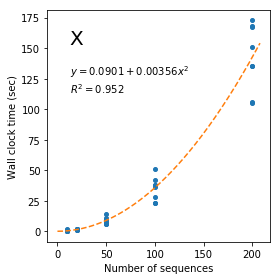

In [106]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['Taxa'], df['Wall'], 'o', markersize=4)
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x ** 2
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g %+.3g \it{x}^2$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'X', size=20, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('mafft.taxa.pdf', bbox_to_inches='tight')

#### PASTA/UPP

In [108]:
df = pd.read_table('data/pasta_taxa.tsv')
df.head()

,Gene,Taxa,Wall,CPU,RAM
0,p0031,10,73.42,6.09,50440
1,p0031,20,12.59,10.82,56048
2,p0031,50,30.95,30.20,61472
3,p0031,100,79.07,78.95,67592
4,p0031,200,179.64,179.99,76004


In [109]:
df = df.query('Gene != "p0060" and Taxa <= 200')

In [110]:
reg = sp.stats.linregress(df['Taxa'].values, df['Wall'].values)
reg

LinregressResult(slope=0.99704850746268647, intercept=-3.8064365671641696, rvalue=0.97106914036799996, pvalue=3.0654040152618676e-25, stderr=0.039774610449312159)

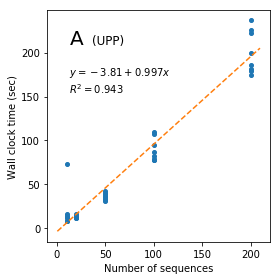

In [111]:
fig = plt.figure(figsize=(4, 4))
ax = plt.gca()
plt.plot(df['Taxa'], df['Wall'], 'o', markersize=4)
x0, x1 = plt.xlim()
y0 = x0 * reg.slope + reg.intercept
y1 = x1 * reg.slope + reg.intercept
plt.plot([x0, x1], [y0, y1], '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g %+.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)
plt.text(0.2, 0.85, '(UPP)', size=12, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('pasta.taxa.pdf', bbox_to_inches='tight')

#### Calculation

In [ ]:
def mafft_n(x):
    return 0.0901 + 0.00356 * x ** 2

In [122]:
def pasta_n(x):
    return -3.81 + 0.997 * x

In [ ]:
df.query('uniq_in < 500')['uniq_in'].apply(mafft_n).sum() / 3600

In [ ]:
df.query('uniq_in >= 500')['uniq_in'].apply(pasta_n).sum() / 3600

In [124]:
df['uniq_in'].apply(pasta_n).sum() / 3600

2784.3971316666675

### Tree building

#### FastTree

In [94]:
df = pd.read_table('data/fasttree_taxa.tsv')
df = df.query('Gene != "p0060" and Taxa <= 200')
df['RAM'] = df['RAM'] / 1000
df.head()

,Gene,Taxa,Wall,CPU,RAM
0,p0031,10,0.39,0.35,4.192
1,p0031,20,0.88,0.86,5.044
2,p0031,50,2.67,2.64,7.152
3,p0031,100,6.87,6.86,10.408
4,p0031,200,14.55,14.48,17.736


In [95]:
# O(n log n)
reg = sp.stats.linregress(df['Taxa'].values * np.log(df['Taxa'].values), df['Wall'].values)
reg

LinregressResult(slope=0.014718991072852012, intercept=0.12367497993745591, rvalue=0.99323154250902934, pvalue=3.8273150043267422e-37, stderr=0.00027922832351581322)

/Users/qiz173/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/qiz173/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


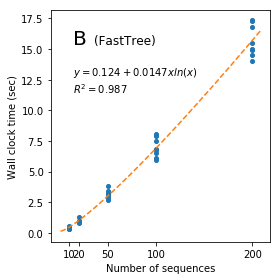

In [96]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['Taxa'], df['Wall'], 'o')
plt.xticks(df['Taxa'].unique())
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x * np.log(x)
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g %+.3g \it{x}ln(\it{x})$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'B', size=20, transform=ax.transAxes)
plt.text(0.2, 0.85, '(FastTree)', size=12, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('fasttree.taxa.pdf', bbox_to_inches='tight')

#### RAxML

In [125]:
df = pd.read_table('data/raxml_taxa.tsv')
df = df.query('Gene != "p0060" and Taxa <= 200')
df['RAM'] = df['RAM'] / 1000
df.head()

,Gene,Taxa,Wall,CPU,RAM
0,p0031,10,10.68,10.60,5.028
1,p0031,20,38.57,38.24,9.584
2,p0031,50,364.40,364.32,25.056
3,p0031,100,1154.43,1154.31,53.844
4,p0031,200,4479.00,4304.09,118.824


In [126]:
# the power of 1.4 was recommended by Wayne
reg = sp.stats.linregress(df['Taxa'].values ** 1.4, df['Wall'].values)
reg

LinregressResult(slope=2.2024515402647218, intercept=-115.44239814871753, rvalue=0.96963667459322722, pvalue=7.5834699985507895e-25, stderr=0.090110055648235377)

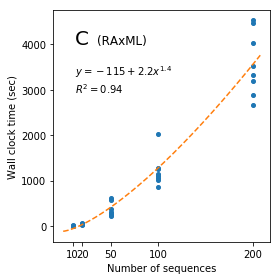

In [127]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['Taxa'], df['Wall'], 'o')
plt.xticks(df['Taxa'].unique())
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x ** 1.4
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g %+.3g \it{x}^{1.4}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'C', size=20, transform=ax.transAxes)
plt.text(0.2, 0.85, '(RAxML)', size=12, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('raxml.taxa.pdf', bbox_to_inches='tight')

In [128]:
reg = sp.stats.linregress(df['Taxa'].values, df['RAM'].values)
reg

LinregressResult(slope=0.693039759535655, intercept=-5.3643217247097823, rvalue=0.98324490672914866, pvalue=1.0594927893791698e-29, stderr=0.020843288781866219)

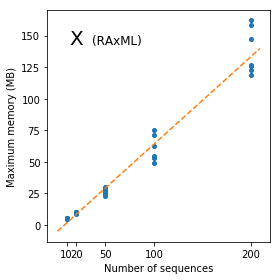

In [101]:
fig = plt.figure()
plt.plot(df['Taxa'], df['RAM'], 'o')
plt.xticks(df['Taxa'].unique())
x0, x1 = plt.xlim()
y0 = x0 * reg.slope + reg.intercept
y1 = x1 * reg.slope + reg.intercept
plt.plot([x0, x1], [y0, y1], '--')
plt.xlabel('Number of sequences')
plt.ylabel('Maximum memory (MB)')
ax = plt.gca()
plt.text(0.1, 0.85, 'X', size=20, transform=ax.transAxes)
plt.text(0.2, 0.85, '(RAxML)', size=12, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('raxml.taxa.ram.pdf', bbox_to_inches='tight')

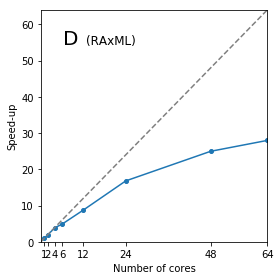

In [102]:
df = pd.read_table('data/raxml_cores.tsv').query('Model == "CAT"')
fig = plt.figure()
plt.plot(df['Cores'], df['SpeedUp'], '-o')
plt.xticks(df['Cores'].unique())
plt.plot([0, 64], [0, 64], '--k', c='C7')
plt.xlim([0, 64])
plt.ylim([0, 64])
plt.xlabel('Number of cores')
plt.ylabel('Speed-up')
ax = plt.gca()
plt.text(0.1, 0.85, 'D', size=20, transform=ax.transAxes)
plt.text(0.2, 0.85, '(RAxML)', size=12, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('raxml.cores.pdf', bbox_to_inches='tight')

#### Calculation

In [129]:
def raxml(x):
    return 2.162 * x ** 1.4

In [ ]:
def fasttree(x):
    return 0.0785 * x

In [132]:
df['uniq_in'].apply(raxml).sum() / 3600

66540.817149656548

In [ ]:
df['uniq_in'].max()

In [ ]:
raxml(df['uniq_in'].max()) / 3600

### Genome insertion

#### INSTRAL

In [88]:
df = pd.read_table('data/instral.tsv', sep=' ')
df.head()

,Rep,Backbone_size,Pruned_leaf,RT
0,1,10000,4321,1166.757
1,1,10000,4461,1209.121
2,1,10000,4610,1162.529
3,1,5000,1229,485.948
4,1,5000,1426,423.076


Linear in log space

In [20]:
reg = sp.stats.linregress(np.log(df['Backbone_size'].values), np.log(df['RT'].values))
reg

LinregressResult(slope=1.0980947983318228, intercept=-3.7901504787956264, rvalue=0.97714434746601753, pvalue=0.0, stderr=0.0036596650992151186)

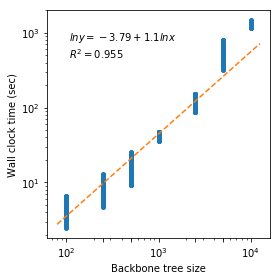

In [34]:
fig = plt.figure()
plt.plot(df['Backbone_size'], df['RT'], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xticks(df['Backbone_size'].unique())
x0, x1 = plt.xlim()
y0 = np.exp(np.log(x0) * reg.slope + reg.intercept)
y1 = np.exp(np.log(x1) * reg.slope + reg.intercept)
plt.plot([x0, x1], [y0, y1], '--')
plt.xlabel('Backbone tree size')
plt.ylabel('Wall clock time (sec)')
ax = plt.gca()
plt.text(0.1, 0.8, '$ln\it{y} = %.3g %+.3g ln\it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
fig.tight_layout()
fig.savefig('instral.size.pdf', bbox_to_inches='tight')

In [41]:
np.exp(-3.79 + 1.1 * np.log(10575))

603.57650678323591

Quadratic in log space

In [92]:
reg = sp.stats.linregress(np.log(df['Backbone_size'].values) ** 2, np.log(df['RT'].values))
reg

LinregressResult(slope=0.086279635564757512, intercept=-0.42279802231762975, rvalue=0.98824757949408792, pvalue=0.0, stderr=0.00020444931884171829)

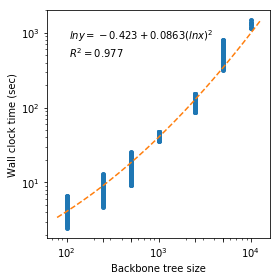

In [97]:
fig = plt.figure()
plt.plot(df['Backbone_size'], df['RT'], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xticks(df['Backbone_size'].unique())
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = np.exp(reg.intercept + reg.slope * np.log(x) ** 2)
plt.plot(x, y, '--')
plt.xlabel('Backbone tree size')
plt.ylabel('Wall clock time (sec)')
ax = plt.gca()
plt.text(0.1, 0.8, '$ln\it{y} = %.3g %+.3g (ln\it{x})^2$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
fig.tight_layout()
fig.savefig('instral.size.pdf', bbox_to_inches='tight')

In [96]:
np.exp(-0.423 + 0.0863 * np.log(10575) ** 2)

1082.4770769722099

### HGT prediction

#### Ranger-DTL

In [606]:
df = pd.read_table('data/ranger-dtl.tsv').query('0 < Time <= 450')
df.head()

,Gene,Genomes,Taxa,Time,Memory
1,PF00006.24,107,340,314.016,0.968
3,PF00012.19,78,118,67.368,0.364
4,PF00015.20,34,148,14.248,0.348
5,PF00016.19,12,17,0.052,0.196
6,PF00033.18,31,31,2.460,0.272


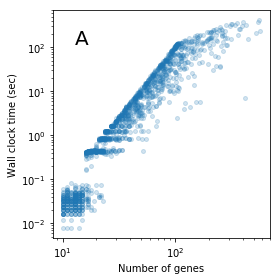

In [607]:
fig = plt.figure()
plt.plot(df['Taxa'], df['Time'], 'o', alpha=0.2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of genes')
plt.ylabel('Wall clock time (sec)')
ax = plt.gca()
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('ranger.genes.pdf', bbox_to_inches='tight')

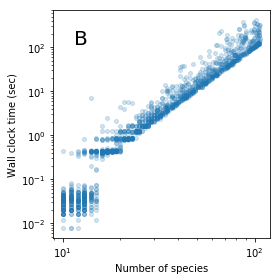

In [608]:
fig = plt.figure()
plt.plot(df['Genomes'], df['Time'], 'o', alpha=0.2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of species')
plt.ylabel('Wall clock time (sec)')
ax = plt.gca()
plt.text(0.1, 0.85, 'B', size=20, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('ranger.species.pdf', bbox_to_inches='tight')

Multiple linear regression

In [609]:
reg = LinearRegression().fit(np.log(df[['Taxa', 'Genomes']]), np.log(df['Time']))

In [610]:
reg.coef_

array([ 1.19072398,  2.41867145])

In [611]:
reg.intercept_

-11.784108039928469

In [612]:
x = np.arange(df['Taxa'].min(), df['Taxa'].max(), 10)
y = np.arange(df['Genomes'].min(), df['Genomes'].max(), 10)
X, Y = np.meshgrid(x, y)

In [613]:
def func(x, y):
    return np.exp(reg.intercept_ + reg.coef_[0] * np.log(x) + reg.coef_[1] * np.log(y))

In [614]:
zs = np.array([func(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

In [619]:
%matplotlib notebook

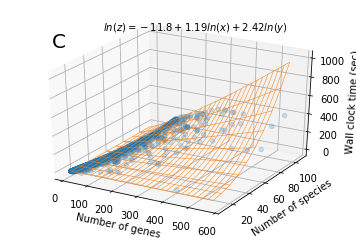

In [622]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Taxa'], df['Genomes'], df['Time'], alpha=0.2)
ax.plot_wireframe(X, Y, Z, color='C1', linewidths=0.5)
ax.set_xlabel('Number of genes')
ax.set_ylabel('Number of species')
ax.set_zlabel('Wall clock time (sec)')
ax.text(200, 0, 1600, '$ln(z) = %.3g %+.3g ln(x) %+.3g ln(y)$'
             % (reg.intercept_, reg.coef_[0], reg.coef_[1]))
ax.text(0, 0, 1350, 'C', size=20);

In [595]:
fig.tight_layout()
fig.savefig('ranger.3d.pdf', bbox_to_inches='tight')

In [621]:
%matplotlib inline

#### DIAMOND

In [193]:
columns = ['size', 'ellapsed', 'system', 'user', 'average', 'maximum']
df = pd.read_table('data/diamond.size.tsv', names=columns)
df['runtime'] = df['ellapsed'].apply(hms2s)
df['memory'] = df['maximum'] / 1000000
df.head()

,size,ellapsed,system,user,average,maximum,runtime,memory
0,100000,5:07:51,267347.20,1768.19,0,14578792,18471.00,14.578792
1,50000,3:02:04,156559.79,1178.54,0,12072236,10924.00,12.072236
2,20000,1:50:23,89367.80,966.05,0,10477660,6623.00,10.477660
3,10000,1:01:43,45423.22,691.85,0,14644928,3703.00,14.644928
4,5000,40:59.19,25961.28,547.47,0,12114628,2459.19,12.114628


In [194]:
reg = sp.stats.linregress(df[['size', 'runtime']].values)
reg

LinregressResult(slope=0.17742435613172369, intercept=1421.046156233057, rvalue=0.99170841271011112, pvalue=2.0473919750632468e-08, stderr=0.008128603959272309)

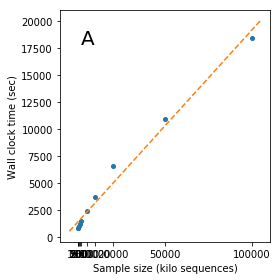

In [196]:
fig = plt.figure()
plt.plot(df['size'], df['runtime'], 'o')
plt.xticks(df['size'])
x0, x1 = plt.xlim()
y0 = x0 * reg.slope + reg.intercept
y1 = x1 * reg.slope + reg.intercept
plt.plot([x0, x1], [y0, y1], '--')
plt.xlabel('Sample size (kilo sequences)')
plt.ylabel('Wall clock time (sec)')
ax = plt.gca()
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('diamond.size.pdf', bbox_to_inches='tight')

In [200]:
columns = ['cores', 'ellapsed', 'system', 'user', 'average', 'maximum']
df = pd.read_table('data/diamond.cores.tsv', names=columns)
df['runtime'] = df['ellapsed'].apply(hms2s)
df['memory'] = df['maximum'] / 1000000
df.head()

,cores,ellapsed,system,user,average,maximum,runtime,memory
0,16,15:02.72,7149.21,199.78,0,7453912,902.72,7.453912
1,12,20:38.29,6073.41,250.73,0,7382224,1238.29,7.382224
2,8,21:45.17,4750.25,231.75,0,7074620,1305.17,7.074620
3,4,28:44.48,4364.06,238.77,0,6891652,1724.48,6.891652
4,2,42:45.62,4003.94,238.84,0,6760600,2565.62,6.760600


In [201]:
base = float(df.query('cores == 1')['runtime'])
df['speedup'] = base / df['runtime']

In [202]:
df['speedup']

0    4.757843
1    3.468493
2    3.290759
3    2.490606
4    1.674059
5    1.000000
Name: speedup, dtype: float64

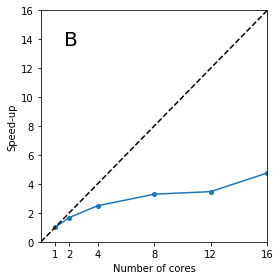

In [191]:
fig = plt.figure()
plt.plot(df['cores'], df['speedup'], '-o')
plt.plot([0, 16], [0, 16], '--k')
plt.xticks(df['cores'].unique())
plt.xlim([0, 16])
plt.ylim([0, 16])
plt.xlabel('Number of cores')
plt.ylabel('Speed-up')
ax = plt.gca()
plt.text(0.1, 0.85, 'B', size=20, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('diamond.cores.pdf', bbox_to_inches='tight')

#### Calculation

In [147]:
%%script false
def ranger(x, y):
    return 14.71 - 1.76 * x + 0.0247 * x ** 2 + 0.344 * y + 0.000399 * y ** 2

In [148]:
def ranger(x, y):  # genes, species
    return np.exp(-11.8 + 1.19 * np.log(x) + 2.42 * np.log(y))

In [159]:
times = df[['all_in', 'genomes_in']].apply(lambda x: ranger(*x), axis=1) / 3600
times.head()

#cluster
AAAC01000001.1_4976     0.085217
AAFV01000278.1_2       15.311071
AAKL01000024.1_28       0.430972
AARM02000317.1_1        3.186808
AARY02000029.1_9       85.653348
dtype: float64

In [160]:
times[times < 1680].shape

(45367,)

In [163]:
45367 / 45692

0.992887157489276

In [161]:
times[times < 1680].sum()

625323.35381152388

In [158]:
times.sum()

31162846881.063297

In [140]:
df[['all_in', 'genomes_in']].apply(lambda x: ranger(*x), axis=1).max() / 3600

454667.06846046576

In [149]:
df[['all_in', 'genomes_in']].apply(lambda x: ranger(*x), axis=1).sum() / 3600

8656346.3558509164

In [ ]:
# 10.23 million queries
# 20000 each, 6623 secs

In [198]:
10.23 * 1000000 / 20000 * 6623 * 16 / 3600

15056.286666666667

### Metagenome profiling

#### CAMI

In [43]:
df = pd.read_table('data/cami.tsv')
df.shape[0]

80

In [44]:
# simplify sample IDs
df['Sample'] = df['Sample'].apply(
    lambda x: 'S1' if x.startswith('S')
    else ('H%s' % x[-1] if x.startswith('H')
          else 'M%s%s' % (x[1], ('a' if 'S001' in x else 'b'))))

In [45]:
# convert memory to GB
df['Memory'] = df['Memory'] / 1000000

In [46]:
# convert wall clock time to seconds
df['Runtime'] = df['Ellapsed'].apply(hms2s)

In [47]:
df.head()

,Dataset,Database,Program,Tree,Sample,Sequences,Basepairs,Ellapsed,User,System,Memory,Runtime
0,low,11K,Centrifuge,False,S1,147848026,14784802600,18:25.7,24601.47,5553.28,19.843432,1105.7
1,low,11K,Kraken,False,S1,147848026,14784802600,17:12.1,9504.35,9414.51,272.591560,1032.1
2,low,11K,Kraken,True,S1,147848026,14784802600,38:54.2,9709.67,1745.93,272.582416,2334.2
3,low,11K,Burst,False,S1,147848026,14784802600,58:35.6,64537.58,687.48,238.167632,3515.6
4,low,11K,UTree,False,S1,147848026,14784802600,07:47.0,12142.28,81.43,10.647940,467.0


Sample sizes

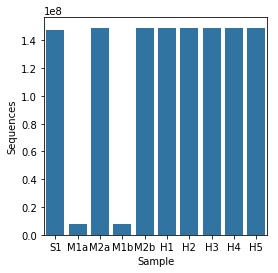

In [56]:
ax = sns.barplot(x='Sample', y='Sequences', color=sns.color_palette()[0],
                 data=df.drop_duplicates(subset='Sample', keep='first'));

Custom legend

In [171]:
sample2dataset = dict(df[['Sample', 'Dataset']].values.tolist())
sample2dataset

{'S1': 'low',
 'M1a': 'medium',
 'M2a': 'medium',
 'M1b': 'medium',
 'M2b': 'medium',
 'H1': 'high',
 'H2': 'high',
 'H3': 'high',
 'H4': 'high',
 'H5': 'high'}

In [172]:
palette = sns.color_palette('Set1')

In [173]:
labels = ['low', 'medium', 'high']
cmap = {k: palette[labels.index(v)] for k, v in sample2dataset.items()}
handles = [Line2D([0], [0], color=palette[i]) for i in range(3)]

Overall performance

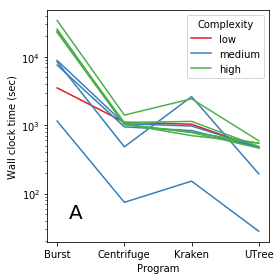

In [174]:
ax = sns.lineplot(x='Program', y='Runtime', hue='Sample', palette=cmap, legend=False,
                  data=df.query('Database == "11K" and Tree == False'))
ax.set_yscale('log')
ax.set_ylabel('Wall clock time (sec)')
ax.legend(handles, labels, title='Complexity')
ax.set_ylabel('Wall clock time (sec)')
ax.text(0.1, 0.1, 'A', size=20, transform=ax.transAxes)
savepdf(ax.get_figure(), 'sample.time.pdf')

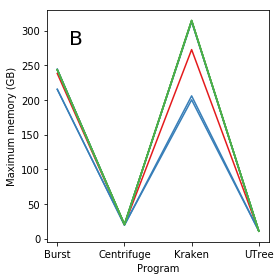

In [175]:
ax = sns.lineplot(x='Program', y='Memory', hue='Sample', palette=cmap, legend=False,
                  data=df.query('Database == "11K" and Tree == False'))
ax.set_ylabel('Maximum memory (GB)')
ax.text(0.1, 0.85, 'B', size=20, transform=ax.transAxes)
savepdf(ax.get_figure(), 'sample.ram.pdf')

Tree vs. no tree

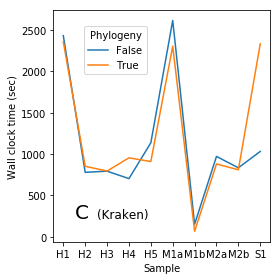

In [180]:
# Kraken
ax = sns.lineplot(x='Sample', y='Runtime', hue='Tree', data=df.query('Program == "Kraken" and Database == "11K"'))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], title='Phylogeny', loc='upper left', bbox_to_anchor=(0.12, 0.95))
ax.set_ylabel('Wall clock time (sec)')
ax.text(0.1, 0.1, 'C', size=20, transform=ax.transAxes)
ax.text(0.2, 0.1, '(Kraken)', size=12, transform=ax.transAxes)
savepdf(ax.get_figure(), 'phylo.kraken.pdf')

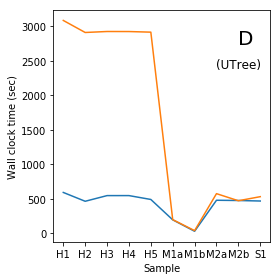

In [181]:
# UTree
ax = sns.lineplot(x='Sample', y='Runtime', hue='Tree', data=df.query('Program == "UTree"'), legend=False)
ax.set_ylabel('Wall clock time (sec)')
ax.text(0.85, 0.85, 'D', size=20, transform=ax.transAxes)
ax.text(0.75, 0.75, '(UTree)', size=12, transform=ax.transAxes)
savepdf(ax.get_figure(), 'phylo.utree.pdf')

ToL vs stdb

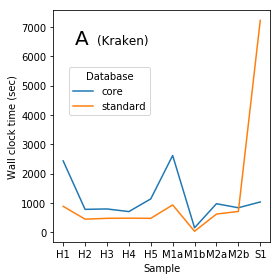

In [49]:
ax = sns.lineplot(x='Sample', y='Runtime', hue='Database', data=df.query('Program == "Kraken" and Tree == False'))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['core', 'standard'], title='Database', loc='center left', bbox_to_anchor=(0.05, 0.65))
ax.set_ylabel('Wall clock time (sec)')
ax.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)
ax.text(0.2, 0.85, '(Kraken)', size=12, transform=ax.transAxes)
savepdf(ax.get_figure(), 'db.kraken.time.pdf')

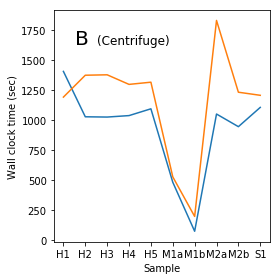

In [110]:
ax = sns.lineplot(x='Sample', y='Runtime', hue='Database', data=df.query('Program == "Centrifuge" and Tree == False'), legend=False)
ax.set_ylabel('Wall clock time (sec)')
ax.text(0.1, 0.85, 'B', size=20, transform=ax.transAxes)
ax.text(0.2, 0.85, '(Centrifuge)', size=12, transform=ax.transAxes)
savepdf(ax.get_figure(), 'db.centrifuge.time.pdf')

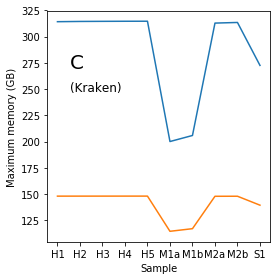

In [111]:
ax = sns.lineplot(x='Sample', y='Memory', hue='Database', data=df.query('Program == "Kraken" and Tree == False'), legend=False)
ax.set_ylabel('Maximum memory (GB)')
ax.text(0.1, 0.75, 'C', size=20, transform=ax.transAxes)
ax.text(0.1, 0.65, '(Kraken)', size=12, transform=ax.transAxes)
savepdf(ax.get_figure(), 'db.kraken.ram.pdf')

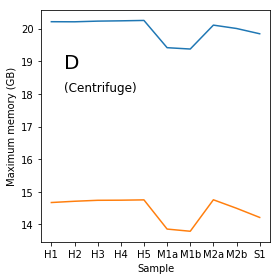

In [112]:
ax = sns.lineplot(x='Sample', y='Memory', hue='Database', data=df.query('Program == "Centrifuge" and Tree == False'), legend=False)
ax.set_ylabel('Maximum memory (GB)')
ax.text(0.1, 0.75, 'D', size=20, transform=ax.transAxes)
ax.text(0.1, 0.65, '(Centrifuge)', size=12, transform=ax.transAxes)
savepdf(ax.get_figure(), 'db.centrifuge.ram.pdf')

#### Scalability by cores

In [52]:
columns = ['cores', 'ellapsed', 'system', 'user', 'average', 'maximum']

In [50]:
def plot_speedup(program, letter):
    df = pd.read_table('data/%s.cores.txt' % program, names=columns)
    df['runtime'] = df['ellapsed'].apply(hms2s)
    df['memory'] = df['maximum'] / 1000000
    df = df[['cores', 'runtime', 'memory']]
    base = float(df.query('cores == 1')['runtime'])
    df['speedup'] = base / df['runtime']
    plt.plot(df['cores'], df['speedup'], '-o')
    plt.xticks(df['cores'].unique())
    plt.plot([0, 32], [0, 32], '--k')
    plt.xlim([0, 32])
    plt.ylim([0, 32])
    plt.xlabel('Number of cores')
    plt.ylabel('Speed-up')
    ax = plt.gca()
    plt.text(0.1, 0.85, letter, size=20, transform=ax.transAxes)
    plt.text(0.2, 0.85, '(%s)' % program.capitalize(), size=12, transform=ax.transAxes)
    savepdf(ax.get_figure(), '%s.cores.pdf' % program)

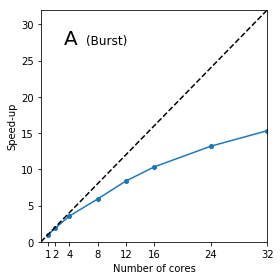

In [53]:
plot_speedup('burst', 'A')

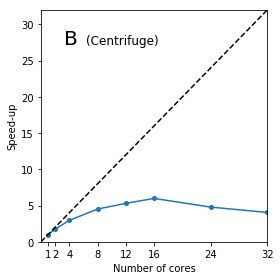

In [54]:
plot_speedup('centrifuge', 'B')

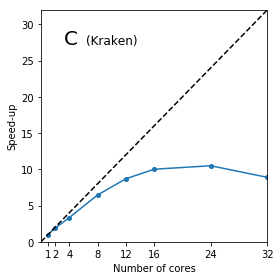

In [55]:
plot_speedup('kraken', 'C')

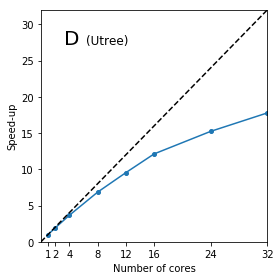

In [56]:
plot_speedup('utree', 'D')

In [58]:
columns = ['cores', 'ellapsed', 'system', 'user', 'average', 'maximum']

In [72]:
program = 'utree'
cores = 12

In [73]:
df = pd.read_table('data/%s.cores.txt' % program, names=columns)
df['runtime'] = df['ellapsed'].apply(hms2s)
df['memory'] = df['maximum'] / 1000000
df = df[['cores', 'runtime', 'memory']]
base = float(df.query('cores == 1')['runtime'])
df['speedup'] = base / df['runtime']

In [74]:
float(df.query('cores == %d' % cores)['runtime']) / float(df.query('cores == 32')['runtime'])

1.863856769861992

#### Scalability by size

In [272]:
def plot_scale_linear(program, letter):
    df = pd.read_table('data/%s.size.txt' % program, names=columns)
    df['runtime'] = df['ellapsed'].apply(hms2s)
    df['memory'] = df['maximum'] / 1000000
    df['size'] = (df['size'] / 1000).astype(int)
    df = df[['size', 'runtime', 'memory']]
    reg = sp.stats.linregress(df[['size', 'runtime']].values)
    fig = plt.figure()
    plt.plot(df['size'], df['runtime'], 'o', markersize=4)
    x = np.array(range(*[int(x) for x in plt.xlim()]))
    y = reg.intercept + reg.slope * x
    plt.plot(x, y, '--')
    ax = plt.gca()
    plt.text(0.1, 0.65, '$\it{y} = %.3g %+.3g \it{x}$\n$\it{R}^2 = %.3g$'
             % (reg.intercept, reg.slope, reg.rvalue ** 2),
             transform=ax.transAxes)
    plt.xlabel('Sample size (kilo seqs)')
    plt.ylabel('Wall clock time (sec)')
    plt.text(0.1, 0.85, letter, size=20, transform=ax.transAxes)
    plt.text(0.2, 0.85, '(%s)' % program.capitalize(), size=12, transform=ax.transAxes)
    fig.tight_layout()
    fig.savefig('%s.size.linear.pdf' % program, bbox_to_inches='tight')

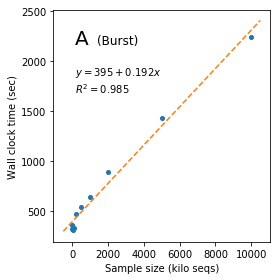

In [310]:
plot_scale_linear('burst', 'A')

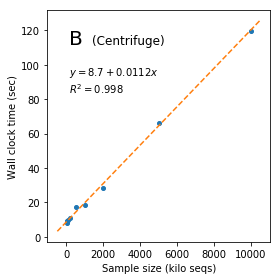

In [311]:
plot_scale_linear('centrifuge', 'B')

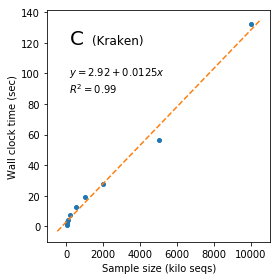

In [312]:
plot_scale_linear('kraken', 'C')

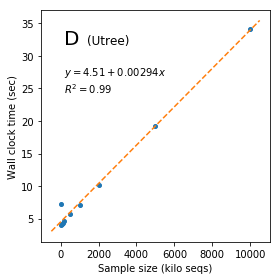

In [313]:
plot_scale_linear('utree', 'D')

##### Test zone

In [203]:
df = pd.read_table('data/burst.size.txt', names=columns)

In [205]:
df['runtime'] = df['ellapsed'].apply(hms2s)
df['memory'] = df['maximum'] / 1000000
df['size'] = (df['size'] / 1000).astype(int)
df = df[['size', 'runtime', 'memory']]
df

,size,runtime,memory
0,10,359.79,213.710416
1,20,325.40,213.710396
2,50,314.26,213.745044
3,100,338.51,213.756760
4,200,473.70,213.772688
5,500,544.46,213.870668
6,1000,644.70,213.993832
7,2000,891.91,214.185008
8,5000,1437.11,214.748696
9,10000,2238.14,215.768808


Linear regression

In [253]:
reg = sp.stats.linregress(df[['size', 'runtime']].values)
reg

LinregressResult(slope=0.19157227019162548, intercept=395.1095538782111, rvalue=0.99233840460948508, pvalue=1.4936760786166139e-08, stderr=0.0084327458737512538)

Text(0.1,0.85,'A')

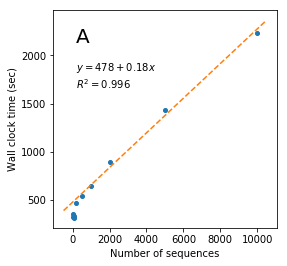

In [258]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['size'], df['runtime'], 'o')
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g + %.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)

Polynomial regression

In [260]:
fit = np.polyfit(df['size'], df['runtime'], 2)
fit

array([ -7.58776371e-06,   2.62764264e-01,   3.59569907e+02])

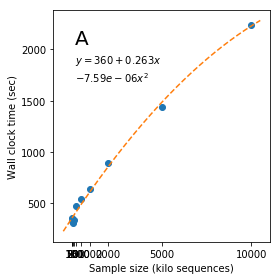

In [267]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['size'], df['runtime'], 'o')
plt.xticks(df['size'])
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = np.poly1d(fit)(x)
plt.plot(x, y, '--')
plt.text(0.1, 0.7, '$\it{y} = %.3g %+.3g \it{x}$\n$%+.3g\it{x}^2$'
         % (fit[2], fit[1], fit[0]), transform=ax.transAxes)
plt.xlabel('Sample size (kilo sequences)')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)

Linear regression with burnin

In [256]:
reg = sp.stats.linregress(df.query('size >= 200')[['size', 'runtime']].values)
reg

LinregressResult(slope=0.17977841916444853, intercept=478.02726027080223, rvalue=0.99778636381598418, pvalue=7.3448541191922408e-06, stderr=0.0059909768581606713)

Text(0.1,0.85,'A')

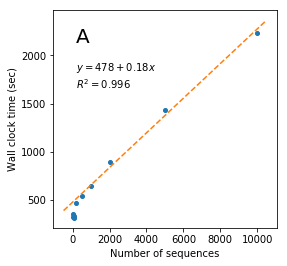

In [259]:
fig = plt.figure()
ax = plt.gca()
plt.plot(df['size'], df['runtime'], 'o', markersize=4)
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g + %.3g \it{x}$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)

In [215]:
sp.stats.pearsonr(df['size'], df['runtime'])[0]

0.99233840460948508

In [208]:
reg = sp.stats.linregress(df[['size', 'runtime']].values)
reg

LinregressResult(slope=0.19157227019162548, intercept=395.1095538782111, rvalue=0.99233840460948508, pvalue=1.4936760786166139e-08, stderr=0.0084327458737512538)

In [ ]:
fig = plt.figure()
ax = plt.gca()
plt.plot(dfx['Taxa'], dfx['Wall'], 'o', markersize=4)
x = np.array(range(*[int(x) for x in plt.xlim()]))
y = reg.intercept + reg.slope * x ** 2
plt.plot(x, y, '--')
plt.text(0.1, 0.65, '$\it{y} = %.3g + %.3g \it{x}^2$\n$\it{R}^2 = %.3g$'
         % (reg.intercept, reg.slope, reg.rvalue ** 2),
         transform=ax.transAxes)
plt.xlabel('Number of sequences')
plt.ylabel('Wall clock time (sec)')
plt.text(0.1, 0.85, 'A', size=20, transform=ax.transAxes)
fig.tight_layout()
fig.savefig('mafft.taxa.pdf', bbox_to_inches='tight')

#### Calculation

In [75]:
# once
def meta(x):
    return ((395 + 0.192 * x) * 1.484 * 16 + (8.7 + 0.0112 * x) * 0.762 * 12 + (2.92 + 0.0125 * x) * 0.889 * 16 + (4.51 + 0.00294 * x) * 1.864 * 12) / 3600

In [82]:
# both
def meta(x):
    return ((395 + 0.192 * x) * 1.484 * 16 + (8.7 + 0.0112 * x) * 0.762 * 12 + (2.92 + 0.0125 * x) * 0.889 * 16 * 2 + (4.51 + 0.00294 * x) * 1.864 * 12 * 2) / 3600

In [87]:
meta(100000) * 1530

222947.232836